## Reinforcement Learning Project

In [314]:
import numpy as np
from typing import Dict, Tuple, List
import csv 
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import matplotlib
import matplotlib.pyplot as plt
import math
import random
import os 
from PIL import Image 
from torch.utils.data import Dataset, DataLoader, SequentialSampler, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import json
from collections import Counter 
from tqdm import tqdm

### Prepare dataset

In [315]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [316]:
class DataProcessor:
    def __init__(self, folder_path, disease_list):
        self.folder_path = folder_path
        self.disease_list = disease_list
        self.folders_with_diseases_labels = {}
        self.folder_name_with_diseases = []
        self.label_counts = None

    def read_data(self):
        for root, dirs, files in os.walk(os.path.join(self.folder_path, 'imgs')):
            for folder_name in dirs:
                folder_path = os.path.join(root, folder_name)
                
                detection_file_path = os.path.join(folder_path, 'detection.json')
                with open(detection_file_path, 'r') as detection_file:
                    detection_data = json.load(detection_file)

                    disease_labels = [label.lower() for item in detection_data for label in item.keys() if label in self.disease_list]
                    
                    for idx, label in enumerate(disease_labels):
                        if label == "effusion":
                            disease_labels[idx] = "pleural effusion"  

                    disease_labels = set(disease_labels) 
                    
                    # merge labels for images with multiple labels
                    if disease_labels:
                        merged_label = '-'.join(sorted(disease_labels))
                        self.folders_with_diseases_labels[folder_name] = merged_label
                        self.folder_name_with_diseases.append(folder_name)

    def delete_folders(self):
        # frequency of each merged label
        self.label_counts = Counter(self.folders_with_diseases_labels.values())

        # delete folders with label counts <= 3
        folders_to_delete = [folder_name for folder_name, label in self.folders_with_diseases_labels.items() if self.label_counts[label] <= 3]

        for folder_name in folders_to_delete:
            del self.folders_with_diseases_labels[folder_name]
            self.folder_name_with_diseases.remove(folder_name)
            
    def get_training_data(self):
        training_data = []
        for folder_name, label in self.folders_with_diseases_labels.items():
            folder_path = os.path.join(self.folder_path, 'imgs', folder_name)
            image_path = os.path.join(folder_path, 'source.jpg')
            training_data.append((image_path, label))
        return training_data


folder_path = 'Slake1.0'
disease_list = ['Pneumothorax', 'Pneumonia', 'Effusion', 'Lung Cancer']
data_processor = DataProcessor(folder_path, disease_list)
data_processor.read_data()
data_processor.delete_folders()
data = data_processor.get_training_data()

In [317]:
SUPPORTED_CONDITIONS = set(dict(data).values())
num_classes=len(SUPPORTED_CONDITIONS)

In [318]:
#split training-test set
training_data, validation_data = train_test_split(data, test_size=0.2, random_state=42, shuffle = True, stratify=np.array(data)[:,1])

train_labels = [x[1] for x in training_data]
train_label_counts = dict(Counter(train_labels))
train_weight_samples = [1/train_label_counts[x] for x in train_labels]

In [319]:
train_sampler = WeightedRandomSampler(train_weight_samples, num_samples=len(train_labels), replacement=True)
train_dataloader = DataLoader(training_data, sampler=train_sampler, batch_size=2)

val_sampler = SequentialSampler(validation_data)
val_dataloader = DataLoader(validation_data, sampler=val_sampler, batch_size=1)

### Prepare training environment

In [320]:
# RL Environment 
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class Env: 
    _condition_symptom_probabilities: Dict[str, Dict[str, float]] # conditions with symptoms and their probabilities
    _actions: list[str] # symptoms
    _init_state: np.array
    _current_state: np.array
    _img: np.array
    _condition: str # the condition which the simulated patient has
    _symptoms_of_condition: Dict[str, float] # symptoms of the condition which the simulated patient has
    _supported_conditions : list[str]
    
    def __init__(self,
                 img: np.array, 
                 condition: str
                ) -> None:  
        self._supported_conditions= ["pneumonia", "pneumothorax", "lung cancer", "pleural effusion"]
        self._img = img
        #if(condition is None): 
        #    condition = random.sample(self._supported_conditions,1)[0]
        self._condition = condition

        # init condition_symptom_probabilities from HealthKnowledgeGraph.csv
        self._condition_symptom_probabilities = self.load_condition_symptom_probabilities()
        # init condition_symptom_probabilities from slake knowledge graph 
        #self._condition_symptom_probabilities= dict()
        #with open('Slake1.0/KG/en_disease.csv', newline='') as csvfile:
        #    reader = csv.reader(csvfile, delimiter='#')
        #    reader.__next__() # skip header 
        #    for row in reader:
        #        if(row[1]!="symptom"):
        #            continue
        #        if(row[0] not in self._supported_conditions):
        #            continue
        #        self._condition_symptom_probabilities[row[0]] = dict()
        #        n_symptoms=len(row[2].split(','))
        #        uniform_prob = 1/(2**n_symptoms)
        #        for symptom in row[2].split(','):
        #            #assign uniform conditional probability because no conditional probability are available 
        #            self._condition_symptom_probabilities[row[0]][symptom.strip()] = uniform_prob

        # check if condition is valid
        if(self._condition not in self._condition_symptom_probabilities.keys()):
            raise ValueError('Unknow Condition: ' + condition + '. Please choose one of the following: ' + str(self._condition_symptom_probabilities.keys()))
        
        # init symptoms_of_condition for easier access
        self._symptoms_of_condition = self._condition_symptom_probabilities[self._condition]

        # init actions
        self._actions = list()
        for condition in self._condition_symptom_probabilities.keys(): 
            for symptom in list(self._condition_symptom_probabilities[condition]):
                if symptom not in self._actions:
                    self._actions.append(symptom) 

        # init init_state = vector with cnn output (probabilities per condition) and history of asked symptoms (0=not asked, 1=symptom is present, -1=symptom is not present)
        visual_prior = np.random.uniform(size=(len(self._condition_symptom_probabilities.keys()))) #TODO: replace with cnn output
        visual_prior = np.ones(shape=(len(self._condition_symptom_probabilities.keys())))
        self._init_state = np.concatenate((visual_prior,np.zeros((len(self._actions)))), axis=0)
        self._current_state = self._init_state

    def load_condition_symptom_probabilities(self) -> Dict[str, Dict[str, float]]:
        condition_symptom_probabilities = dict()

        with open('HealthKnowledgeGraph.csv', newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            # skip header
            header = next(reader)  
            for row in reader:
                # to make it case insensitive
                condition = row[0].lower() 
                
                # if condition is in the supported conditions list then add the symptoms to the list
                if condition not in self._supported_conditions:
                    continue

                symptoms_and_probs = row[1].split(',')
                symptom_probabilities = dict()
                for symptom_prob in symptoms_and_probs:
                    # example for symptom_prob: pain (0.318)
                    symptom, prob = map(str.strip, symptom_prob.split('('))
                    # to remove the last parentheses ')'
                    prob = float(prob[:-1])  
                    symptom_probabilities[symptom] = prob
                condition_symptom_probabilities[condition] = symptom_probabilities 
        return condition_symptom_probabilities
    
    def posterior_of_condition(self, condition: str, useAddition=False) -> float: 
        #TODO: What is the correct likelihood calculation? If we use multiplication as in P(x,y)=P(x)*P(y), the likelihood gets smaller 
        #and nothing prevents the model from asking symptoms which are not related to the condition.
        if(useAddition):
            likelihood=0 
        else:
            likelihood=1
        for idx, symptom in enumerate(self._actions):
            patient_answer = self._current_state[idx+len(self._condition_symptom_probabilities.keys())]
            #if (patient_answer==1) and (symptom not in self._condition_symptom_probabilities[condition].keys()):
            #    likelihood*= 0
            #elif (patient_answer==-1) and (symptom not in self._condition_symptom_probabilities[condition].keys()):
            #    likelihood*=1
            if (symptom not in self._condition_symptom_probabilities[condition].keys()):
                #TODO: Do we have to punish the model if a symptom is positive and is not related to the condition?
                continue 
            elif patient_answer==1:
                if(useAddition):
                    likelihood+=self._condition_symptom_probabilities[condition][symptom]
                else:
                    likelihood*=self._condition_symptom_probabilities[condition][symptom]
            elif patient_answer==-1:
                if(useAddition):
                    likelihood+=(1-self._condition_symptom_probabilities[condition][symptom]) 
                else:
                    likelihood*=(1-self._condition_symptom_probabilities[condition][symptom]) 

        prior = self._current_state[list(self._condition_symptom_probabilities.keys()).index(condition)]
        if(useAddition):
            result = likelihood+prior
        else:
            result = likelihood*prior
        return result
    
    def reward(self) -> float:
        #TODO: Is it a problem when the reward gets smaller and smaller?
        punishment=0
        for i in range(len(self._actions)):
            patient_answer = self._current_state[i+len(self._condition_symptom_probabilities.keys())]
            if (patient_answer!=0):
                punishment+=0.1
        return self.posterior_of_condition(self._condition, useAddition=True)-punishment
    
    def has_symptom(self, symptom: str) -> bool:
        if symptom not in self._symptoms_of_condition:
            return False
        else:
            phi = np.random.uniform()
            return phi <= self._symptoms_of_condition[symptom]

    def step(self, action_idx: int) -> Transition: 
        action = self._actions[action_idx]
        old_state = self._current_state.copy()
        self._current_state[len(self._condition_symptom_probabilities.keys()) + action_idx] = 1 if self.has_symptom(action) else -1
        
        return Transition(old_state, action_idx, self._current_state, self.reward())
    
    def reset(self) -> np.array:
        self._current_state = self._init_state
        return self._current_state

In [342]:
print(myEnv._condition_symptom_probabilities)

{'lung cancer': {'shortness of breath': 0.129, 'coughing': 0.108, 'weakness': 0.086, 'lesion': 0.046, 'lethargy': 0.037, 'back pain': 0.033, 'fever': 0.032, 'fatigue': 0.026, 'cough with phlegm': 0.023, 'coughing up blood': 0.022, 'nausea': 0.022, 'infection': 0.021, 'constipation': 0.02, 'confusion': 0.018, 'low oxygen in the body': 0.017, 'malaise': 0.016, 'lump': 0.016, 'chronic cough': 0.015, 'wheezing': 0.015, 'fast heart rate': 0.014, 'mental confusion': 0.014, 'sharp pain': 0.011, 'weight loss': 0.01, 'dehydration': 0.01, 'difficulty swallowing': 0.01, 'dry cough': 0.01, 'skin rash': 0.009, 'chills': 0.009}, 'pleural effusion': {'shortness of breath': 0.186, 'coughing': 0.116, 'low oxygen in the body': 0.047, 'lethargy': 0.036, 'fluid in the abdomen': 0.032, 'cough with phlegm': 0.032, 'infection': 0.025, 'weakness': 0.024, 'fluid in the lungs': 0.023, 'fever': 0.023, 'dry cough': 0.022, 'fatigue': 0.022, 'wheezing': 0.021, 'collapse': 0.02}, 'pneumonia': {'coughing': 0.402, 'fe

In [321]:
class ReplayMemory():
    def __init__(self, capacity):
        self.memory=deque([], maxlen=capacity)
    def push(self, transition):
        self.memory.append(transition)
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

In [322]:
# RL model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128, dtype=torch.double)
        self.layer2 = nn.Linear(128, 128, dtype=torch.double)
        self.layer3 = nn.Linear(128, n_actions, dtype=torch.double)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [323]:
# BATCH_SIZE is the number of transitions sampled form the replay buffer
#GAMMA is the discount factor as mentioned in the previous section
#SIZE is the number of transitions sampled from the replay buffer
#EPS START is the starting value of epsilon
#EPS DECAY controls the rate of exposential decay of epsilon, higher means a slower decay
#EPS END is the final value of epsilon
#TAU is the update rate of the target network 
#LR the learning rate of the Adams optimizar
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-5

#Get number of actions from dummy env
myEnv=Env(np.array([]), 'pneumonia') 
n_actions = len(myEnv._actions)
n_observations = len(myEnv._current_state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0 

In [324]:
def optimize_model(losses, gradient_norms):
    if len(memory) < BATCH_SIZE: 
        return
    transitions = memory.sample(BATCH_SIZE)
    #converts batch_array of Transitions to Transition of batch_arrays
    batch = Transition(*zip(*transitions))

    next_state_batch = torch.tensor(batch.next_state)
    state_batch = torch.tensor(batch.state)
    action_batch = torch.tensor(batch.action)
    reward_batch = torch.tensor(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch[None,:])

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values = target_net(next_state_batch).max(1)[0]

    #TODO: state_action_values grow infinitely
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values.squeeze(), expected_state_action_values)

    losses.append(loss.detach())

    parameters = [p for p in policy_net.parameters() if p.grad is not None and p.requires_grad]
    if len(parameters) == 0:
        total_norm = 0.0
    else: 
        total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()).to(device) for p in parameters]), 2.0).item()
    gradient_norms.append(total_norm)
    
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(policy_net.parameters(),100)
    optimizer.step()

In [325]:
def select_action(myEnv, state, epsilon):
    randnum = np.random.rand(1)
    if randnum < epsilon:
        action_idx = np.random.randint(len(myEnv._actions))
    else:
        with torch.no_grad():
            action_idx = np.argmax(policy_net(torch.tensor(state))).item() 
    
    return action_idx

### Start with training

In [326]:
num_epochs = 400
len_episode = 10
i_decay=1
epsilon = EPS_START
losses=[]
gradient_norms=[]
rewards=[]
epsilons=[]
total_reward_per_episode=[]

for _ in tqdm(range(num_epochs)):
    for batch in train_dataloader: 
        condition = batch[1][0]
        myEnv=Env(np.array([]), condition)
        state = myEnv.reset()
        for _ in range(len_episode):
            if epsilon > EPS_END:
                epsilon = EPS_START * math.exp(-i_decay/EPS_DECAY)
                i_decay+=1 
            epsilons.append(epsilon)
            action_idx = select_action(myEnv, state, epsilon)
            transition = myEnv.step(action_idx)
            rewards.append(transition.reward)
            last_reward=transition.reward
            memory.push(transition)
            state = transition.next_state
            optimize_model(losses, gradient_norms)
    
            #Soft update of target  network weights
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)
        total_reward_per_episode.append(last_reward) 

print("complete") 

100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [32:34<00:00,  4.89s/it]

complete


In [327]:
# helper function
def averagewindow(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)))
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

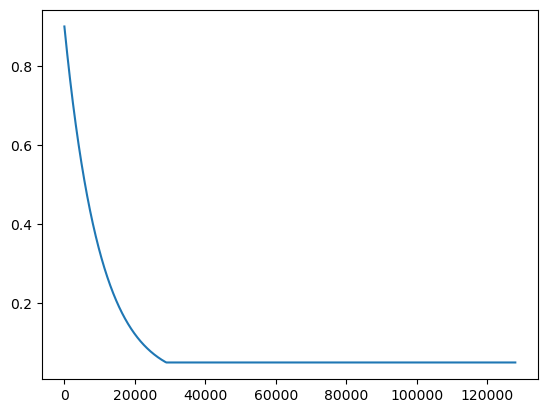

In [328]:
plt.plot(epsilons)

Text(0.5, 1.0, 'losses')

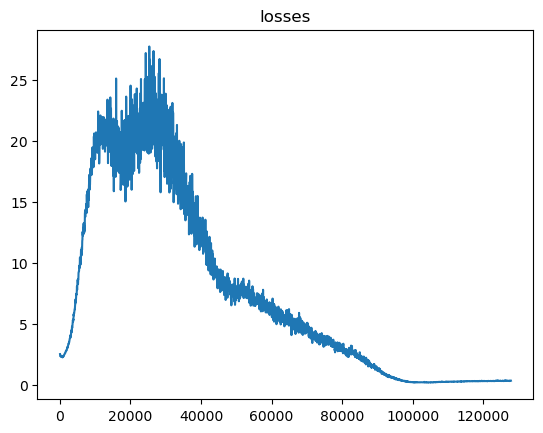

In [329]:
t,y = averagewindow(losses, d=50)
plt.plot(t,y)
plt.title("losses")

Text(0.5, 1.0, 'gradient norms')

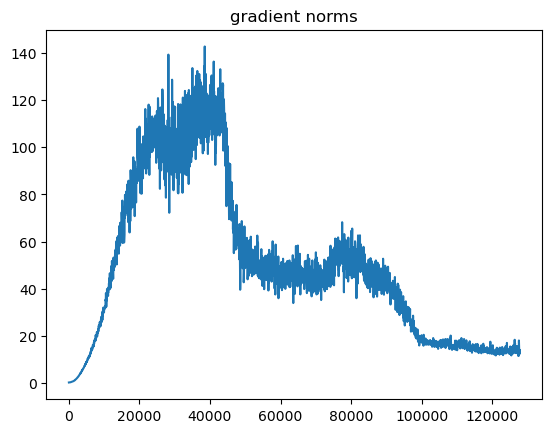

In [330]:
t,y = averagewindow(gradient_norms, d=50)
plt.plot(t,y)
plt.title("gradient norms")

Text(0.5, 1.0, 'Rewards')

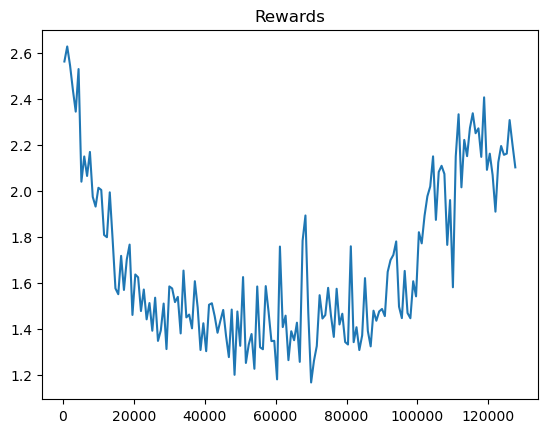

In [331]:
t,y = averagewindow(rewards, d=800)
plt.plot(t,y)
plt.title("Rewards")

Text(0.5, 1.0, 'Total reward per episode')

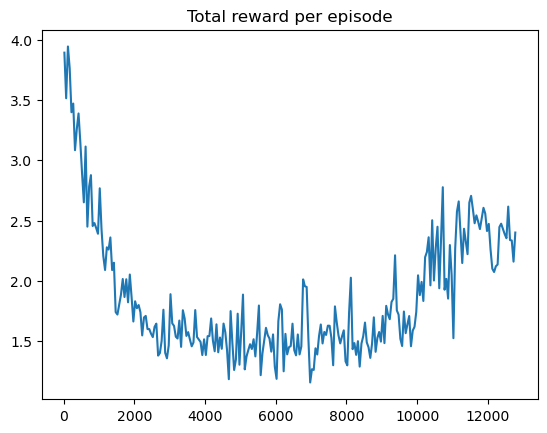

In [332]:
t,y = averagewindow(total_reward_per_episode, d=50)
plt.plot(t,y)
plt.title("Total reward per episode")

### Evaluation

In [333]:
def topKAccuracy(k=3):
    epsilon = 0
    N_samples=0
    N_correct_samples=0
    for sample in test:
        N_samples+=1
        sample_condition = "" # include condition
        myEnv=Env(np.array([]), condition=sample_condition) # TODO: include picture
        state = myEnv.reset()
        for _ in range(len_episodes):
            action_idx = select_action(myEnv, state, epsilon)
            transition = myEnv.step(action_idx)
            state = transition.next_state
        posterior_of_conditions = []
        for condition in myEnv._supported_conditions:
            posterior = myEnv.posterior_of_condition(condition, useAddition=False)
            posterior_of_conditions.append((posterior, condition))
        posterior_of_conditions.sort(key=lambda x: x[0]) 
        sample_k = next(x for x, val in enumerate(posterior_of_conditions)
                                  if val == sample_condition)
        if(sample_k <= k):
            N_correct_samples+=1
    return N_correct_samples / N_samples

### Test cases

In [337]:
#Testing simulated patient answers
myTestEnv=Env(np.array([]), 'pneumothorax')
print("Symptoms for Pertussis:")
print(myTestEnv._condition_symptom_probabilities['pneumothorax'])
print("Expected uniform conditional proabability: 1\(", 2**len(myTestEnv._condition_symptom_probabilities['pneumothorax'].keys()), ")")
n=0
prob=0
for i in range(10000):
    n+=1
    if myTestEnv.has_symptom('pain'):
        prob+=1 
print("\n Probability of spastic cough after 10000 samples: " + str(prob/n))

Symptoms for Pertussis:
{'shortness of breath': 0.116, 'pain': 0.086, 'rib pain': 0.053, 'coughing': 0.05, 'chest pain worsened by breathing': 0.033, 'discomfort': 0.022, 'bruising': 0.018, 'collapse': 0.017, 'back pain': 0.014, 'seizures': 0.013, 'fast heart rate': 0.012, 'chest discomfort': 0.011, 'cavity': 0.01, 'infection': 0.009, 'wheezing': 0.009, 'difficulty breathing': 0.009, 'shoulder pain': 0.009, 'confusion': 0.008, 'respiratory distress': 0.008, 'chronic cough': 0.008}
Expected uniform conditional proabability: 1\( 1048576 )

 Probability of spastic cough after 10000 samples: 0.0867


In [338]:
#Testing reward
myTestEnv=Env(np.array([]), 'pneumothorax')
print("prior of condition:")
print(myTestEnv._current_state[list(myTestEnv._condition_symptom_probabilities.keys()).index("pneumothorax")])

myTestEnv.step(myTestEnv._actions.index('coughing'))
result=myTestEnv._current_state[len(myTestEnv._condition_symptom_probabilities.keys()) + list(myTestEnv._actions).index('coughing')] 
print("Probability of coughing: " + str(myTestEnv._condition_symptom_probabilities['pneumothorax']['coughing']))
print("Result patient asking if he has coughing: " + str(result))

myTestEnv.step(myTestEnv._actions.index('pain'))
result=myTestEnv._current_state[len(myTestEnv._condition_symptom_probabilities.keys()) + list(myTestEnv._actions).index('pain')] 
print("Probability of pain: " + str(myTestEnv._condition_symptom_probabilities['pneumothorax']['pain']))
print("Result patient asking if he has pain: " + str(result))

myTestEnv.step(myTestEnv._actions.index('shortness of breath'))
result=myTestEnv._current_state[len(myTestEnv._condition_symptom_probabilities.keys()) + list(myTestEnv._actions).index('shortness of breath')] 
print("Probability of shortness of breath: " + str(myTestEnv._condition_symptom_probabilities['pneumothorax']['shortness of breath']))
print("Result patient asking if he has shortness of breath: " + str(result))

print("Reward: " + str(myTestEnv.reward()))

prior of condition:
1.0
Probability of coughing: 0.05
Result patient asking if he has coughing: -1.0
Probability of pain: 0.086
Result patient asking if he has pain: 1.0
Probability of shortness of breath: 0.116
Result patient asking if he has shortness of breath: -1.0
Reward: 2.62
